### Setup

In [43]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
from numpy.linalg import multi_dot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, silhouette_samples
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from pyvis.network import Network
from scipy.spatial.distance import pdist, squareform
from umap import UMAP
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [44]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [45]:
# Specify all directories

# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
# Directory of proteins of interest
dir_proteins = '/home/louiscam/projects/gpcr/data/protein_families/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
saving_main_dir = '/home/louiscam/projects/gpcr/save/figures_main/'
saving_supp_dir = '/home/louiscam/projects/gpcr/save/figures_supplement/'

# Load data

In [46]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [47]:
# Mapping gene to chromosome
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)
# Mapping gene to locus
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
# Mapping locus to gene
with open(saving_dir+'locus2gene.pkl', 'rb') as f:
    locus2gene = pickle.load(f)

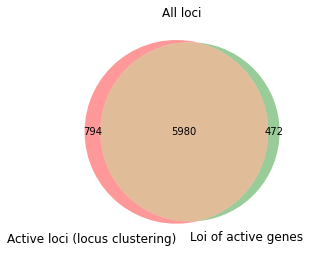

In [48]:
# Active/inactive loci (from clustering)
with open(saving_dir+'all_active_loci.pkl', 'rb') as f:
    all_active_loci_from_clustering = pickle.load(f)
with open(saving_dir+'all_inactive_loci.pkl', 'rb') as f:
    all_inactive_loci_from_clustering = pickle.load(f)

# Active/inactive genes (from clustering)
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes = pickle.load(f)

# Define active/inactive loci as the loci of active/inactive genes
all_active_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in active_genes])))
all_inactive_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in inactive_genes])))
plt.figure()
venn2(subsets = (set(all_active_loci), set(all_active_loci_from_clustering)), 
      set_labels = ('Active loci (locus clustering)', 'Loi of active genes'))
plt.title('All loci')
plt.show()

# Redefine all active loci as the intersection between active loci determined directly by clustering'
# and all loci of active genes
all_active_loci = np.unique(list(set(all_active_loci).intersection(set(all_active_loci_from_clustering))))
all_inactive_loci = np.array(list(set(all_inactive_loci)-set(all_active_loci)))

In [49]:
# Adhesome genes and loci
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'active_adhesome_genes_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)

In [50]:
# Import list of all blacklisted loci
with open(dir_processed_hic+f'blacklist_IMR90_{norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

# Select loci that are far from adhesome loci

In [51]:
# Select all active non blacklisted loci that contain at least one gene
loci_containing_genes = np.unique(list(itertools.chain.from_iterable(list(gene2locus.values()))))
selected_active_loci0 = np.unique(list(set(all_active_loci).intersection(set(loci_containing_genes))
                                      -set(blacklist_list)))
print(f'Number of selected active loci = {len(selected_active_loci0)}')

Number of selected active loci = 5623


In [52]:
# Extract adhesome loci
selected_active_adhesome_loci = [loc for loc in active_adhesome_loci if loc in selected_active_loci0]

# Or if we have a precise gene list
c1 = np.array(['SHARPIN', 'HRAS', 'SLC16A3', 'CD151', 'PLEC', 'UBE2I'])
c2 = np.array(['CFL1', 'PIP5K1C', 'PKD1'])
c3 = np.array(['CAPN1', 'MAPK8IP3', 'PIAS4', 'STAT3'])
c4 = np.array(['GRB2', 'RNF185'])
c5 = np.array(['SHC1', 'TESK1', 'TLN1'])
c6 = np.array(['CRKL', 'ITGB2'])
c7 = np.array(['RAVER1', 'POLR2A'])
gene_list = np.concatenate([c1, c3])

selected_active_adhesome_loci = [gene2locus[g] for g in gene_list]
selected_active_adhesome_loci = list(itertools.chain.from_iterable(selected_active_adhesome_loci))
selected_active_adhesome_loci = np.unique(selected_active_adhesome_loci)

In [53]:
# Refine selected_active_loci to only those belonging to other chromosomes than selected_active_adhesome_loci
selected_adhesome_chroms = np.unique([loc.split('_')[1] for loc in selected_active_adhesome_loci])
selected_active_loci = [loc for loc in selected_active_loci0 
                                 if (loc.split('_')[1] not in selected_adhesome_chroms) ]
print(f'Number of selected active loci = {len(selected_active_loci)}')

Number of selected active loci = 4539


In [54]:
# Load Hi-C proximity matrix and scale it
with open(saving_dir+f'contacts_df_negcontrol_{norm}.pkl', 'rb') as f:
    contacts_df1 = pickle.load(f)
max_val = contacts_df1.max().max()
contacts_df1 = contacts_df1/max_val

<Figure size 432x288 with 0 Axes>

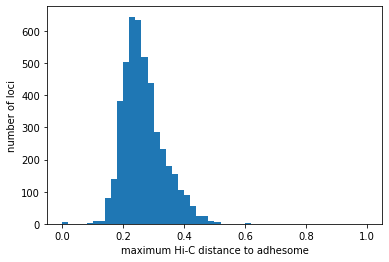

In [55]:
# Select loci that are far away from adhesome
max_hic_to_adhesome_df = contacts_df1.loc[selected_active_loci, selected_active_adhesome_loci]
max_hic_to_adhesome_df = max_hic_to_adhesome_df.max(axis=1)
max_hic_to_adhesome_df = max_hic_to_adhesome_df.to_frame('max_hic')


# Plot histogram
plt.figure()
max_hic_to_adhesome_df.plot.hist(bins=np.arange(0, 1.01, 0.02), legend=False)
plt.xlabel('maximum Hi-C distance to adhesome')
plt.ylabel('number of loci')
plt.show()

# Select lower quantile
q_hic = np.quantile(max_hic_to_adhesome_df.values, 0.1)

In [56]:
q_hic

0.19260945811912628

# Select loci that are not coregulated with adhesome

In [57]:
# Load coregulation marks for all active loci
df_allloci_norm = pd.read_csv(saving_dir+'features_matrix_all_loci_norm.csv', header=0, index_col=0)
selected_df = df_allloci_norm.loc[:, selected_active_loci0]
selected_corr_df = selected_df.corr(method='pearson')

<Figure size 432x288 with 0 Axes>

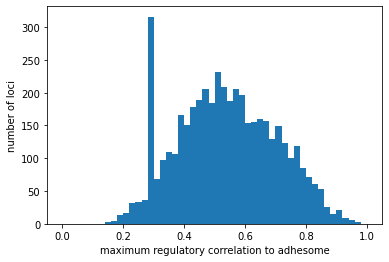

In [58]:
# Select loci that are not coregualted away from adhesome
selected_active_loci_corr = [loc for loc in selected_active_loci if (loc in selected_corr_df.index)]
max_corr_to_adhesome_df = selected_corr_df.loc[selected_active_loci_corr, selected_active_adhesome_loci]
max_corr_to_adhesome_df = np.abs(max_corr_to_adhesome_df)
max_corr_to_adhesome_df = max_corr_to_adhesome_df.max(axis=1)
max_corr_to_adhesome_df = max_corr_to_adhesome_df.to_frame('max_corr')

# Plot histogram
plt.figure()
max_corr_to_adhesome_df.plot.hist(bins=np.arange(0, 1.01, 0.02), legend=False)
plt.xlabel('maximum regulatory correlation to adhesome')
plt.ylabel('number of loci')
plt.show()

# Select lower quantile
q_corr = np.quantile(max_corr_to_adhesome_df.values, 0.1)

In [59]:
q_corr

0.2997977701738914

Note: the big peak at ~0.36 is due to some of the loci having 0 regulatory marks values (there are 275 such loci). This can be checked directly by identifying thee loci and lookign them up in the unnormalized regulatory marks table
- Loci to check: max_corr_to_adhesome_df[max_corr_to_adhesome_df.duplicated('max_corr')].index.tolist()
- Unnormalized marks table: pd.read_csv(saving_dir+'features_matrix_all_loci_nonorm.csv', header=0, index_col=0)

### Visualize loci on Hi-C/correlation plot

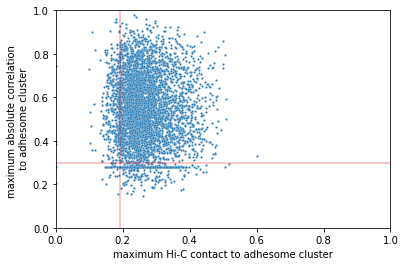

In [60]:
# Merge data frames
far_loci_df = pd.concat([max_hic_to_adhesome_df, max_corr_to_adhesome_df], join='inner', axis=1)
plt.figure()
sns.scatterplot(data=far_loci_df, x='max_hic', y='max_corr', s=5)
plt.vlines(x=q_hic, ymin=0, ymax=1, color='red', alpha=0.3)
plt.hlines(y=q_corr, xmin=0, xmax=1, color='red', alpha=0.3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('maximum Hi-C contact to adhesome cluster')
plt.ylabel('maximum absolute correlation \n to adhesome cluster')
plt.show()

In [61]:
# Select loci that are far in HiC and weakly correlated with selected adhesome cluster
selected_far_loci_df = far_loci_df[(far_loci_df['max_hic']<q_hic) & (far_loci_df['max_corr']<q_corr)]
far_loci = selected_far_loci_df.index.values
print(f'Number of loci selected = {len(far_loci)}')

Number of loci selected = 46


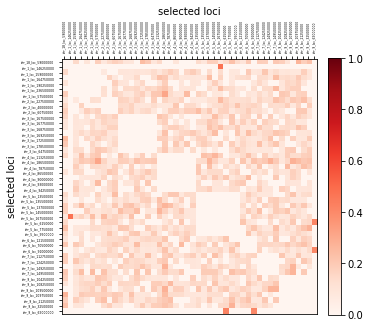

In [63]:
# Visualize Hi-C contacts between these loci
save_to = saving_supp_dir+f'suppfig_12b.pdf'
#save_to = saving_supp_dir+f'suppfig_13b.pdf'

lu.plot_heatmap(df=contacts_df1.loc[far_loci, far_loci], 
                xticklabels=far_loci, yticklabels=far_loci,
                xlabel='selected loci', ylabel='selected loci',
                size=5,
                vmax=1, vmin=0, cmap='Reds',
                save_to=save_to)

In [64]:
# Table of loci pairs for negative validation
contacts_between_selected_loci = contacts_df1.loc[far_loci, far_loci].unstack().reset_index()
contacts_between_selected_loci.columns = ['locus_1', 'locus_2', 'hic']
contacts_between_selected_loci = contacts_between_selected_loci.sort_values('hic')
contacts_between_selected_loci['chr1'] = [int(loc.split('_')[1]) 
                                          for loc in contacts_between_selected_loci['locus_1']]
contacts_between_selected_loci['chr2'] = [int(loc.split('_')[1]) 
                                          for loc in contacts_between_selected_loci['locus_2']]
contacts_between_selected_loci = contacts_between_selected_loci[
    contacts_between_selected_loci['chr1']<contacts_between_selected_loci['chr2']
]
contacts_between_selected_loci['genes_1'] = [locus2gene[loc] for loc in contacts_between_selected_loci['locus_1']]
contacts_between_selected_loci['genes_2'] = [locus2gene[loc] for loc in contacts_between_selected_loci['locus_2']]

In [66]:
# Only select far loci with 0 pairwise Hi-C contacts
pd.set_option('display.max_rows', 300)
top_contacts_between_selected_loci = contacts_between_selected_loci[
    contacts_between_selected_loci['hic']==0
]
print(f'Total number of selected pairs = {len(top_contacts_between_selected_loci)}')
top_contacts_between_selected_loci.to_csv(saving_supp_dir+f'suppfig_12d.csv', sep='\t')
# top_contacts_between_selected_loci.to_csv(saving_supp_dir+f'suppfig_13d.csv', sep='\t')
top_contacts_between_selected_loci

Total number of selected pairs = 242


,locus_1,locus_2,hic,chr1,chr2,genes_1,genes_2
1041,chr_4_loc_93000000,chr_5_loc_6250000,0.0,4,5,"[EF565118, GRID2]","[FLJ33360, MED10, UBE2QL1]"
1045,chr_4_loc_93000000,chr_6_loc_70500000,0.0,4,6,"[EF565118, GRID2]","[COL19A1, LMBRD1]"
1046,chr_4_loc_93000000,chr_6_loc_91000000,0.0,4,6,"[EF565118, GRID2]","[BACH2, MAP3K7, MIR4464]"
1049,chr_4_loc_93000000,chr_7_loc_149250000,0.0,4,7,"[EF565118, GRID2]","[KRBA1, SSPO, ZNF467, ZNF767]"
1050,chr_4_loc_93000000,chr_7_loc_149500000,0.0,4,7,"[EF565118, GRID2]","[AL162052, ATP6V0E2, ATP6V0E2-AS1, DQ590227, S..."
1051,chr_4_loc_93000000,chr_9_loc_104250000,0.0,4,9,"[EF565118, GRID2]","[GRIN3A, PPP3R2, RNF20]"
1055,chr_4_loc_93000000,chr_9_loc_21250000,0.0,4,9,"[EF565118, GRID2]","[IFNA1, IFNA13, IFNA2, IFNA22P, IFNA5, IFNA6, ..."
1058,chr_4_loc_94250000,chr_18_loc_59000000,0.0,4,18,[GRID2],[CDH20]
1038,chr_4_loc_93000000,chr_5_loc_137000000,0.0,4,5,"[EF565118, GRID2]","[HNRNPA0, KLHL3, MYOT, NPY6R, PKD2L2]"
1090,chr_4_loc_94250000,chr_6_loc_121500000,0.0,4,6,[GRID2],[C6ORF170]


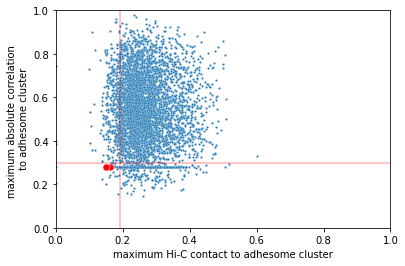

In [67]:
# Merge data frames
pair = contacts_between_selected_loci.loc[1041, ['locus_1', 'locus_2']].values
far_loci_df = pd.concat([max_hic_to_adhesome_df, max_corr_to_adhesome_df], join='inner', axis=1)
plt.figure()
sns.scatterplot(data=far_loci_df, x='max_hic', y='max_corr', s=5)
sns.scatterplot(data=far_loci_df.loc[pair,:], x='max_hic', y='max_corr', s=50, color='red')
plt.vlines(x=q_hic, ymin=0, ymax=1, color='red', alpha=0.3)
plt.hlines(y=q_corr, xmin=0, xmax=1, color='red', alpha=0.3)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('maximum Hi-C contact to adhesome cluster')
plt.ylabel('maximum absolute correlation \n to adhesome cluster')
plt.savefig(saving_supp_dir+'suppfig_12a.pdf', format='pdf')
# plt.savefig(saving_supp_dir+'suppfig_13a.pdf', format='pdf')
plt.show()

# Negative control

We are looking for active genes that
- Do not interact in Hi-C
- Have a low regulatory correlation

In [9]:
# Select all active non blacklisted loci that contain at least one gene
loci_containing_genes = np.unique(list(itertools.chain.from_iterable(list(gene2locus.values()))))
selected_active_loci = np.unique(list(set(all_active_loci).intersection(set(loci_containing_genes))
                                      -set(blacklist_list)))
print(f'Number of selected active loci = {len(selected_active_loci)}')

Number of selected active loci = 5623


In [10]:
# Extract adhesome loci
selected_active_adhesome_loci = [loc for loc in active_adhesome_loci if loc in selected_active_loci]

In [11]:
# Load Hi-C proximity matrix and scale it
with open(saving_dir+f'contacts_df_negcontrol_{norm}.pkl', 'rb') as f:
    contacts_df1 = pickle.load(f)
max_val = contacts_df1.max().max()
contacts_df1 = contacts_df1/max_val

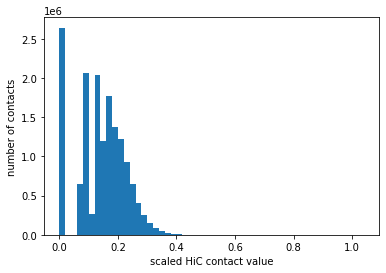

In [12]:
# Plot distribution of Hi-C values
hic_contacts = contacts_df1.values
y_hic = hic_contacts[np.triu_indices(n=len(hic_contacts),k=1)]
hic_threshold = 0
plt.figure()
plt.hist(y_hic, bins=np.arange(0,1.05, 0.02))
#plt.yscale('log')
plt.xlabel('scaled HiC contact value')
plt.ylabel('number of contacts')
plt.show()
# Loci that are far apart in HiC
selected_hic_df = (contacts_df1<=hic_threshold).astype(int)
np.fill_diagonal(selected_hic_df.values, 0)

In [13]:
# Only select pairs of loci with 0 Hi-C contact
selected_hic_df = contacts_df1
hic_edgelist = selected_hic_df.stack().reset_index()
hic_edgelist.columns = ['locus_0', 'locus_1', 'hic']
hic_edgelist = hic_edgelist.set_index(['locus_0', 'locus_1'])
hic_edgelist = hic_edgelist[hic_edgelist['hic']==0]

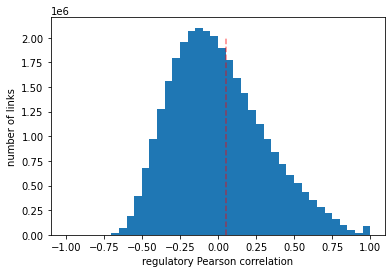

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [162]:
# Rank by coregulation
df_allloci_norm = pd.read_csv(saving_dir+'features_matrix_all_loci_norm.csv', header=0, index_col=0)
selected_df = df_allloci_norm.loc[:, selected_active_loci]
selected_corr_df0 = selected_df.corr(method='pearson')
coreg_edgelist = selected_corr_df0.stack().reset_index()
coreg_edgelist.columns = ['locus_0', 'locus_1', 'corr']
coreg_edgelist = coreg_edgelist.set_index(['locus_0', 'locus_1'])
reg_threshold = 0.05
plt.figure()
plt.hist(coreg_edgelist['corr'], bins=np.arange(-1,1.05, 0.05))
plt.vlines(x=reg_threshold, ymin=0, ymax=2e6, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('regulatory Pearson correlation')
plt.ylabel('number of links')
plt.show()
coreg_edgelist = coreg_edgelist[-reg_threshold<coreg_edgelist['corr']<reg_threshold]

In [138]:
# Join and add information
selected_edgelist = pd.concat([hic_edgelist, coreg_edgelist], axis=1, join='inner')
selected_edgelist = selected_edgelist.reset_index()
selected_edgelist['chr1'] = selected_edgelist['locus_0'].str.split('_', expand=True)[1].astype(int)
selected_edgelist['chr2'] = selected_edgelist['locus_1'].str.split('_', expand=True)[1].astype(int)
selected_edgelist['genes_locus_0'] = [locus2gene[selected_edgelist.iloc[i]['locus_0']] 
                                        for i in range(len(selected_edgelist))]
selected_edgelist['genes_locus_1'] = [locus2gene[selected_edgelist.iloc[i]['locus_1']] 
                                        for i in range(selected_edgelist.shape[0])]

In [139]:
# Filter out pairs containing loci on same chromosome
selected_edgelist = selected_edgelist[selected_edgelist['chr1'] != selected_edgelist['chr2']]

In [140]:
# List of clusters of interest
clusters_genes = [['CFL1', 'PIP5K1C', 'PKD1'], ['GRB2', 'RNF185']]
clusters_loci = [np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in c])))
                 for c in clusters_genes]
clusters_loci_combined = sorted(itertools.chain.from_iterable(clusters_loci))

In [141]:
# Exclude loci on same chromosome as adhesome genes of interest
chrom2exclude = np.unique([int(loc.split('_')[1]) for loc in clusters_loci_combined])
selected_edgelist = selected_edgelist[(~selected_edgelist['chr1'].isin(chrom2exclude)) &
                                      (~selected_edgelist['chr2'].isin(chrom2exclude))]

In [142]:
# Compute minimum Hi-C contact in each cluster
np.fill_diagonal(contacts_df1.values, 1)
min_hic_clusters = [contacts_df1.loc[loci,loci].min().min() for loci in clusters_loci]
min_hic_thresh = min(min_hic_clusters)

In [143]:
# Compute distance of gene in a pair to each cluster
selected_edgelist['max_hic_to_adhesome_locus_0'] = [
    contacts_df1.loc[selected_edgelist.loc[i, 'locus_0'], clusters_loci_combined].max() 
    for i in selected_edgelist.index
]
selected_edgelist['max_hic_to_adhesome_locus_1'] = [
    contacts_df1.loc[selected_edgelist.loc[i, 'locus_1'], clusters_loci_combined].max() 
    for i in selected_edgelist.index
]

In [144]:
# Compute average regulatory correlation with adhesome for loci of each pairs
selected_edgelist['corr_to_adhesome_locus_0'] = [
    selected_corr_df0.loc[selected_edgelist.loc[i, 'locus_0'], clusters_loci_combined].mean() 
    for i in selected_edgelist.index
]
selected_edgelist['corr_to_adhesome_locus_1'] = [
    selected_corr_df0.loc[selected_edgelist.loc[i, 'locus_1'], clusters_loci_combined].mean() 
    for i in selected_edgelist.index
]
selected_edgelist['avg_corr_to_adhesome'] = (selected_edgelist['corr_to_adhesome_locus_0']+selected_edgelist['corr_to_adhesome_locus_1'])/2

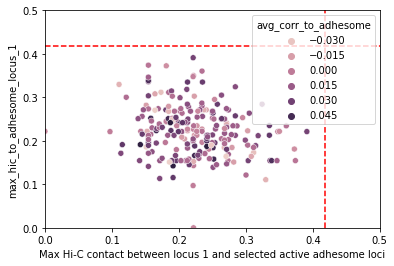

In [145]:
# Plot on scatter plot
plt.figure()
sns.scatterplot(data=selected_edgelist, x='max_hic_to_adhesome_locus_0', y='max_hic_to_adhesome_locus_1', hue='avg_corr_to_adhesome')
plt.vlines(x=min_hic_thresh, ymin=0, ymax=1, color='red', linestyle='dashed')
plt.hlines(y=min_hic_thresh, xmin=0, xmax=1, color='red', linestyle='dashed')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
plt.xlabel('Max Hi-C contact between locus 0 and selected active adhesome loci')
plt.xlabel('Max Hi-C contact between locus 1 and selected active adhesome loci')
plt.show()


In [161]:
# Restrict to pairs of loci taht are far from adhesome loci
tmp = selected_edgelist[(selected_edgelist['max_hic_to_adhesome_locus_0']<0.25) &
                  (selected_edgelist['max_hic_to_adhesome_locus_1']<0.25)]
tmp['sum_chrom'] = tmp['chr1']+tmp['chr2']
tmp.sort_values(['sum_chrom']).head(60)

,locus_0,locus_1,hic,corr,chr1,chr2,genes_locus_0,genes_locus_1,max_hic_to_adhesome_locus_0,max_hic_to_adhesome_locus_1,corr_to_adhesome_locus_0,corr_to_adhesome_locus_1,avg_corr_to_adhesome,sum_chrom
266,chr_2_loc_36750000,chr_1_loc_167000000,0.0,-0.715737,2,1,"[CRIM1, FEZ2, VIT]","[DUSP27, GPA33, POU2F1, RBSG4]",0.243513,0.181125,-0.033954,0.020521,-0.006717,3
170,chr_1_loc_167000000,chr_2_loc_36750000,0.0,-0.715737,1,2,"[DUSP27, GPA33, POU2F1, RBSG4]","[CRIM1, FEZ2, VIT]",0.181125,0.243513,0.020521,-0.033954,-0.006717,3
326,chr_3_loc_56750000,chr_1_loc_247250000,0.0,-0.724259,3,1,"[ARHGEF3, ARHGEF3-AS1]","[BC043220, C1ORF229, MIR3916, VN1R5, ZNF124, Z...",0.244739,0.180994,0.023591,-0.029582,-0.002995,4
312,chr_3_loc_16500000,chr_1_loc_229750000,0.0,-0.734430,3,1,"[BC034913, DAZL, RFTN1]","[TAF5L, URB2]",0.171368,0.113319,-0.028282,0.078726,0.025222,4
186,chr_1_loc_247250000,chr_3_loc_56750000,0.0,-0.724259,1,3,"[BC043220, C1ORF229, MIR3916, VN1R5, ZNF124, Z...","[ARHGEF3, ARHGEF3-AS1]",0.180994,0.244739,-0.029582,0.023591,-0.002995,4
183,chr_1_loc_229750000,chr_3_loc_16500000,0.0,-0.734430,1,3,"[TAF5L, URB2]","[BC034913, DAZL, RFTN1]",0.113319,0.171368,0.078726,-0.028282,0.025222,4
330,chr_3_loc_87000000,chr_2_loc_172500000,0.0,-0.718491,3,2,"[BC050344, VGLL3]","[DYNC1I2, SLC25A12]",0.195782,0.249636,-0.047539,0.070566,0.011513,5
328,chr_3_loc_61500000,chr_2_loc_222250000,0.0,-0.706260,3,2,[PTPRG],"[AX747413, EPHA4]",0.196707,0.234522,0.050473,-0.057531,-0.003529,5
226,chr_2_loc_172500000,chr_3_loc_87000000,0.0,-0.718491,2,3,"[DYNC1I2, SLC25A12]","[BC050344, VGLL3]",0.249636,0.195782,0.070566,-0.047539,0.011513,5
175,chr_1_loc_167250000,chr_4_loc_159500000,0.0,-0.714008,1,4,"[CD247, POU2F1]","[C4ORF46, ETFDH, FNIP2, PPID, RXFP1]",0.221192,0.199239,0.094247,-0.024829,0.034709,5


In [57]:
# Select adhesome loci of interest
selected_adhesome_genes = ['CFL1', 'PIP5K1C', 'PKD1', 'GRB2', 'RNF185']
sub_selected_active_adhesome_loci = [gene2locus[g] for g in selected_adhesome_genes]
sub_selected_active_adhesome_loci = list(itertools.chain.from_iterable(sub_selected_active_adhesome_loci))
sub_selected_active_adhesome_loci = np.unique(sub_selected_active_adhesome_loci)

In [58]:
# Compute average Hi-C contact with adhesome for loci of each pairs
selected_edgelist['hic_to_adhesome_locus_0'] = [
    contacts_df1.loc[selected_edgelist.loc[i, 'locus_0'], sub_selected_active_adhesome_loci].mean() 
    for i in selected_edgelist.index
]
selected_edgelist['hic_to_adhesome_locus_1'] = [
    contacts_df1.loc[selected_edgelist.loc[i, 'locus_1'], sub_selected_active_adhesome_loci].mean() 
    for i in selected_edgelist.index
]

In [59]:
# Compute average regulatory correlation with adhesome for loci of each pairs
selected_edgelist['corr_to_adhesome_locus_0'] = [
    selected_corr_df0.loc[selected_edgelist.loc[i, 'locus_0'], sub_selected_active_adhesome_loci].mean() 
    for i in selected_edgelist.index
]
selected_edgelist['corr_to_adhesome_locus_1'] = [
    selected_corr_df0.loc[selected_edgelist.loc[i, 'locus_1'], sub_selected_active_adhesome_loci].mean() 
    for i in selected_edgelist.index
]
selected_edgelist['avg_corr_to_adhesome'] = (selected_edgelist['corr_to_adhesome_locus_0']+selected_edgelist['corr_to_adhesome_locus_1'])/2

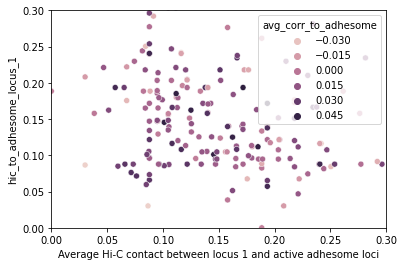

In [60]:
# Plot on scatter plot
plt.figure()
sns.scatterplot(data=selected_edgelist, x='hic_to_adhesome_locus_0', y='hic_to_adhesome_locus_1', hue='avg_corr_to_adhesome')
plt.xlim([0,0.3])
plt.ylim([0,0.3])
plt.xlabel('Average Hi-C contact between locus 0 and active adhesome loci')
plt.xlabel('Average Hi-C contact between locus 1 and active adhesome loci')
plt.show()

In [62]:
# Restrict to pairs of loci taht are far from adhesome loci
selected_edgelist[(selected_edgelist['hic_to_adhesome_locus_0']<0.1) &
                  (selected_edgelist['hic_to_adhesome_locus_1']<0.1)]

,locus_0,locus_1,hic,corr,chr1,chr2,genes_locus_0,genes_locus_1,hic_to_adhesome_locus_0,hic_to_adhesome_locus_1,corr_to_adhesome_locus_0,corr_to_adhesome_locus_1,avg_corr_to_adhesome
74,chr_13_loc_93750000,chr_3_loc_131000000,0.0,-0.757106,13,3,[GPC6],"[LOC339874, MRPL3, NEK11, NUDT16, NUDT16P1, SN...",0.071479,0.076284,-0.052058,0.122190,0.035066
84,chr_14_loc_60750000,chr_6_loc_147750000,0.0,-0.702556,14,6,"[C14ORF39, JB175233, PPM1A, SIX6]",[SAMD5],0.030231,0.086617,0.023109,-0.093619,-0.035255
85,chr_14_loc_62500000,chr_4_loc_158000000,0.0,-0.709282,14,4,"[LINC00643, SYT16]","[GLRB, GRIA2]",0.087836,0.065927,0.065016,-0.000107,0.032454
183,chr_1_loc_229750000,chr_3_loc_16500000,0.0,-0.734430,1,3,"[TAF5L, URB2]","[BC034913, DAZL, RFTN1]",0.059670,0.085029,0.078726,-0.028282,0.025222
305,chr_3_loc_131000000,chr_13_loc_93750000,0.0,-0.757106,3,13,"[LOC339874, MRPL3, NEK11, NUDT16, NUDT16P1, SN...",[GPC6],0.076284,0.071479,0.122190,-0.052058,0.035066
312,chr_3_loc_16500000,chr_1_loc_229750000,0.0,-0.734430,3,1,"[BC034913, DAZL, RFTN1]","[TAF5L, URB2]",0.085029,0.059670,-0.028282,0.078726,0.025222
334,chr_4_loc_158000000,chr_14_loc_62500000,0.0,-0.709282,4,14,"[GLRB, GRIA2]","[LINC00643, SYT16]",0.065927,0.087836,-0.000107,0.065016,0.032454
338,chr_4_loc_166250000,chr_6_loc_102000000,0.0,-0.740152,4,6,"[CPE, JA611274, MIR578, MSMO1]",[GRIK2],0.096661,0.087822,-0.016048,0.077151,0.030552
354,chr_5_loc_157250000,chr_6_loc_102000000,0.0,-0.766548,5,6,[CLINT1],[GRIK2],0.096033,0.087822,-0.055651,0.077151,0.010750
372,chr_6_loc_102000000,chr_4_loc_166250000,0.0,-0.740152,6,4,[GRIK2],"[CPE, JA611274, MIR578, MSMO1]",0.087822,0.096661,0.077151,-0.016048,0.030552


In [90]:
gene2locus['DAPL1']

['chr_2_loc_159500000']

In [91]:
gene2locus['PTPRG']

['chr_3_loc_61500000',
 'chr_3_loc_61750000',
 'chr_3_loc_62000000',
 'chr_3_loc_62250000']

In [116]:
selected_edgelist[(selected_edgelist['locus_1']==gene2locus['PTPRG'][1]) &
                  (selected_edgelist['locus_0']==gene2locus['DAPL1'][0])]

,locus_0,locus_1,hic,corr,chr1,chr2,genes_locus_0,genes_locus_1


In [117]:
selected_edgelist

,locus_0,locus_1,hic,corr,chr1,chr2,genes_locus_0,genes_locus_1
0,chr_10_loc_113750000,chr_6_loc_133250000,0.0,-0.716385,10,6,[GPAM],[LINC00326]
1,chr_10_loc_119750000,chr_10_loc_23500000,0.0,-0.728377,10,10,"[CASC2, RAB11FIP2]","[C10ORF67, OTUD1]"
2,chr_10_loc_120250000,chr_12_loc_51500000,0.0,-0.704234,10,12,"[CACUL1, PRLHR]","[BIN2, CELA1, DAZAP2, GALNT6, LOC494150, POU6F..."
3,chr_10_loc_124000000,chr_4_loc_16750000,0.0,-0.731223,10,4,"[ARMS2, BTBD16, HTRA1, MIR3941, PLEKHA1, TACC2]",[LDB2]
4,chr_10_loc_129000000,chr_20_loc_21000000,0.0,-0.700566,10,20,[DOCK1],"[BC034426, BC042893, PLK1S1]"
...,...,...,...,...,...,...,...,...
479,chr_9_loc_3500000,chr_6_loc_102000000,0.0,-0.753257,9,6,[RFX3],[GRIK2]
480,chr_9_loc_4000000,chr_9_loc_13000000,0.0,-0.724026,9,9,[GLIS3],[MPDZ]
481,chr_9_loc_4000000,chr_9_loc_137250000,0.0,-0.736811,9,9,[GLIS3],"[MIR4669, RXRA]"
482,chr_9_loc_80000000,chr_2_loc_222250000,0.0,-0.730160,9,2,"[GNA14, VPS13A]","[AX747413, EPHA4]"


In [18]:
# Construct list of adjacent triplets
loci_set_list = []
for i in tqdm(range(len(negative_controls_df))):
    node1 = negative_controls_df.iloc[i]['locus1']
    node2 = negative_controls_df.iloc[i]['locus2']
    
    for j in range(i+1, len(negative_controls_df)):
        node3 = negative_controls_df.iloc[j]['locus1']
        node4 = negative_controls_df.iloc[j]['locus2']
        
        if (node1==node3) & (node2.split('_')[1]!=node4.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
        elif (node1==node4) & (node2.split('_')[1]!=node3.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
        elif (node2==node3) & (node1.split('_')[1]!=node4.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
        elif (node2==node4) & (node1.split('_')[1]!=node3.split('_')[1]):
            loci_set_list.append(np.array(sorted(set([node1, node2, node3, node4]))))
loci_set_list = np.unique(loci_set_list, axis=0)

100%|██████████| 160/160 [00:05<00:00, 28.42it/s]


In [19]:
# Add metadata
pd.set_option('max_colwidth', 400)
final_loci_df = pd.DataFrame({'loci_set': list(loci_set_list)})

# Pairwise Hi-C contact among loci
pairwise_hic_values = []
pairwise_hic_within = []
for loci in final_loci_df['loci_set']:
    pairwise_hic_values.append(contacts_df1.loc[loci, loci].values[np.triu_indices(len(loci), 1)])
    pairwise_hic_within.append(np.max(contacts_df1.loc[loci, loci].values[np.triu_indices(len(loci), 1)]))
final_loci_df['hic_values'] = pairwise_hic_values
final_loci_df['hic_strength'] = pairwise_hic_within

# Pairwise coregulation among loci
pairwise_reg_values = []
pairwise_reg_within = []
for loci in final_loci_df['loci_set']:
    pairwise_reg_values.append(selected_corr_df0.loc[loci, loci].values[np.triu_indices(len(loci), 1)])
    pairwise_reg_within.append(np.max(selected_corr_df0.loc[loci, loci].values[np.triu_indices(len(loci), 1)]))
final_loci_df['reg_values'] = pairwise_reg_values
final_loci_df['reg_strength'] = pairwise_reg_within

# Average Hi-C contact with selected adhesome loci
selected_adhesome_genes = ['SHARPIN', 'HRAS', 'SLC16A3', 
                           'CD151', 'PLEC', 'UBE2I', 
                           'CFL1', 'PIP5K1C', 'PKD1', 
                           'SHC1', 'TESK1', 'TLN1']
selected_adhesome_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] 
                                                                      for g in selected_adhesome_genes])))
hic_to_closest_adhesome = []
average_hic_to_adhesome = []
for loci in final_loci_df['loci_set']:
    hic_to_closest_adhesome.append(contacts_df1.loc[loci, selected_adhesome_loci].max().max())
    average_hic_to_adhesome.append(contacts_df1.loc[loci, selected_adhesome_loci].mean().mean())
final_loci_df['hic_to_closest_adhesome'] = hic_to_closest_adhesome
final_loci_df['average_hic_to_adhesome'] = average_hic_to_adhesome

# Average coregulation with adhesome loci
reg_to_closest_adhesome = []
average_reg_to_adhesome = []
for loci in final_loci_df['loci_set']:
    reg_to_closest_adhesome.append(selected_corr_df0.loc[loci, selected_adhesome_loci].max().max())
    average_reg_to_adhesome.append(selected_corr_df0.loc[loci, selected_adhesome_loci].mean().mean())
final_loci_df['reg_to_closest_adhesome'] = reg_to_closest_adhesome
final_loci_df['average_reg_to_adhesome'] = average_hic_to_adhesome

final_loci_df = final_loci_df.sort_values(['hic_strength', 'reg_strength'], ascending=[True, True])
final_loci_df

,loci_set,hic_values,hic_strength,reg_values,reg_strength,hic_to_closest_adhesome,average_hic_to_adhesome,reg_to_closest_adhesome,average_reg_to_adhesome
69,"[chr_15_loc_31750000, chr_6_loc_102000000, chr_7_loc_74000000]","[0.0, 0.0, 0.0]",0.000000,"[-0.7089629776260304, 0.6631244192608599, -0.7211944974439696]",0.663124,0.373970,0.169479,0.842617,0.169479
88,"[chr_2_loc_10500000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.6791738755011261, -0.7338893332708432, -0.7401521128984191]",0.679174,0.355289,0.138919,0.739706,0.138919
106,"[chr_3_loc_56500000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.6892924795724544, -0.7295212180025412, -0.7401521128984191]",0.689292,0.203137,0.105991,0.739706,0.105991
100,"[chr_2_loc_87000000, chr_3_loc_100250000, chr_5_loc_122750000]","[0.0, 0.0, 0.0]",0.000000,"[-0.7279423539358837, -0.700168412219138, 0.6993719830096027]",0.699372,0.265075,0.152152,0.876837,0.152152
109,"[chr_4_loc_166250000, chr_5_loc_157250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.7031155945424487, -0.7401521128984191, -0.7665475158423825]",0.703116,0.271932,0.103766,0.814451,0.103766
...,...,...,...,...,...,...,...,...,...
55,"[chr_14_loc_73500000, chr_3_loc_47750000, chr_6_loc_102000000]","[0.27186989944377343, 0.0, 0.0]",0.271870,"[0.7571124136914913, -0.8076662488432128, -0.7184103278918818]",0.757112,0.354895,0.216203,0.922564,0.216203
19,"[chr_12_loc_51000000, chr_3_loc_47750000, chr_6_loc_102000000]","[0.30667903180376915, 0.0, 0.0]",0.306679,"[0.830041215147353, -0.720346328453393, -0.7184103278918818]",0.830041,0.354895,0.230747,0.922564,0.230747
105,"[chr_3_loc_47750000, chr_6_loc_102000000, chr_7_loc_74000000]","[0.0, 0.3307182347896831, 0.0]",0.330718,"[-0.7184103278918818, 0.8315192051211653, -0.7211944974439696]",0.831519,0.373970,0.235114,0.922564,0.235114
59,"[chr_14_loc_73500000, chr_6_loc_102000000, chr_7_loc_74000000]","[0.0, 0.33360713949774007, 0.0]",0.333607,"[-0.8076662488432128, 0.81194122007367, -0.7211944974439696]",0.811941,0.373970,0.212950,0.842617,0.212950


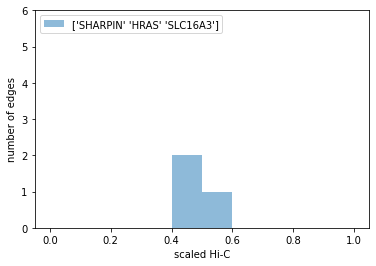

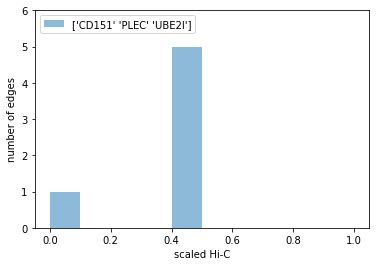

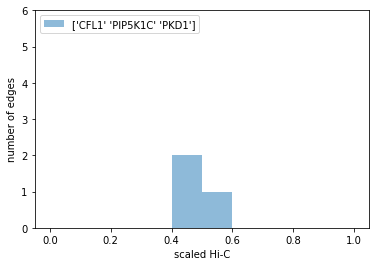

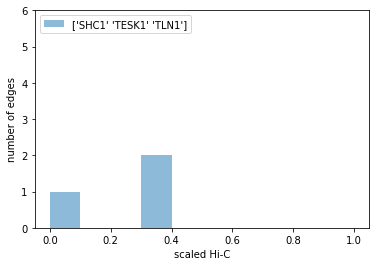

In [20]:
# Histogram of HiC for the positive validation sets
validation_sets = np.array([['SHARPIN', 'HRAS', 'SLC16A3'],['CD151', 'PLEC', 'UBE2I'],
                   ['CFL1', 'PIP5K1C', 'PKD1'], ['SHC1', 'TESK1', 'TLN1']])

for valset in validation_sets:
    val_loci = np.array(list(itertools.chain.from_iterable([gene2locus[g] for g in valset])))
    x = contacts_df1.loc[val_loci, val_loci].values
    plt.figure()
    plt.hist(x[np.triu_indices(len(x), 1)],  bins=np.arange(0,1.1, 0.1), alpha=0.5, label=str(valset))
    plt.legend(loc='upper left')
    plt.ylim([0,6])
    plt.xlabel('scaled Hi-C')
    plt.ylabel('number of edges')
    plt.show()

In [23]:
# Select promising triplets
selected_final_loci_df = final_loci_df[(final_loci_df['hic_strength']<0.1) &
                          (final_loci_df['hic_to_closest_adhesome']<0.25)]
selected_final_loci_df.to_csv(saving_dir+'selected_negative_control_loci.csv', sep=';', header=True)
selected_final_loci_df

,loci_set,hic_values,hic_strength,reg_values,reg_strength,hic_to_closest_adhesome,average_hic_to_adhesome,reg_to_closest_adhesome,average_reg_to_adhesome
106,"[chr_3_loc_56500000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.6892924795724544, -0.7295212180025412, -0.7401521128984191]",0.689292,0.203137,0.105991,0.739706,0.105991
94,"[chr_2_loc_160000000, chr_4_loc_166250000, chr_6_loc_102000000]","[0.0, 0.0, 0.0]",0.000000,"[0.7909965735916539, -0.7510283778917214, -0.7401521128984191]",0.790997,0.229282,0.118639,0.858377,0.118639
1,"[chr_10_loc_124000000, chr_2_loc_159500000, chr_4_loc_16750000]","[0.0, 0.0, 0.0]",0.000000,"[0.8358840393060243, -0.7312233085302212, -0.7102909604785693]",0.835884,0.249406,0.119095,0.858349,0.119095
80,"[chr_20_loc_52500000, chr_2_loc_222250000, chr_3_loc_61500000]","[0.0, 0.0, 0.0]",0.000000,"[-0.70833458536473, 0.8867799889918916, -0.7062601486673616]",0.886780,0.234522,0.130122,0.859443,0.130122
91,"[chr_2_loc_159500000, chr_4_loc_16750000, chr_6_loc_126750000]","[0.0, 0.0, 0.0]",0.000000,"[-0.7102909604785693, 0.9314319947187585, -0.7123071690729694]",0.931432,0.249406,0.113263,0.858349,0.113263
2,"[chr_10_loc_124000000, chr_2_loc_160000000, chr_4_loc_16750000]","[0.07998214476792433, 0.0, 0.0]",0.079982,"[0.8112318744080471, -0.7312233085302212, -0.7031631241237828]",0.811232,0.236208,0.142112,0.858377,0.142112
95,"[chr_2_loc_160000000, chr_4_loc_16750000, chr_6_loc_102000000]","[0.0, 0.0, 0.08526728789352736]",0.085267,"[-0.7031631241237828, -0.7510283778917214, 0.6514411682199357]",0.651441,0.236208,0.132256,0.858377,0.132256
3,"[chr_10_loc_124000000, chr_4_loc_16750000, chr_6_loc_126750000]","[0.0, 0.09428316806123702, 0.0]",0.094283,"[-0.7312233085302212, 0.7908114438239033, -0.7123071690729694]",0.790811,0.236208,0.124098,0.852303,0.124098


In [22]:
# Display genes of final selected loci
selected_final_loci_list = np.unique(list(itertools.chain.from_iterable(selected_final_loci_df['loci_set'])))
pd.DataFrame({'locus': selected_final_loci_list,
              'genes': [locus2gene[loc] for loc in selected_final_loci_list]})

,locus,genes
0,chr_10_loc_124000000,"[ARMS2, BTBD16, HTRA1, MIR3941, PLEKHA1, TACC2]"
1,chr_20_loc_52500000,"[BCAS1, MIR4756]"
2,chr_2_loc_159500000,"[AK126351, DAPL1, PKP4]"
3,chr_2_loc_160000000,"[BAZ2B, TANC1, WDSUB1]"
4,chr_2_loc_222250000,"[AX747413, EPHA4]"
5,chr_3_loc_56500000,"[CCDC66, ERC2, FAM208A]"
6,chr_3_loc_61500000,[PTPRG]
7,chr_4_loc_166250000,"[CPE, JA611274, MIR578, MSMO1]"
8,chr_4_loc_16750000,[LDB2]
9,chr_6_loc_102000000,[GRIK2]
